# Activity 7.2
## Kaden Buckley

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from plotnine import *
#warnings.filterwarnings('ignore')

In [10]:
#Load Data
ames = pd.read_csv("/Users/kadenbuckley/Desktop/MSBA/Fall_Quarter/GSB_544/Data/AmesHousingNew.csv")

#Clean Data
#Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

#Drop other NAs
ames = ames.dropna()

X = ames.drop(["SalePrice"], axis = 1)
y = ames["SalePrice"]

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Part One

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with 
lambda = 1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [11]:
#Create Ordinary Pipeline
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
    ).set_output(transform="pandas")

In [12]:
#Ridge Regression
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)


In [13]:
#Cross-Validation
ridge_scores = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')
linear_scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')
print(ridge_scores)
print(linear_scores)

[0.89627831 0.91741344 0.79268639 0.7825356  0.91432405]
[-1.53191297e+21 -1.11869495e+21 -7.58061593e+21 -1.95369310e+21
 -7.22700549e+22]


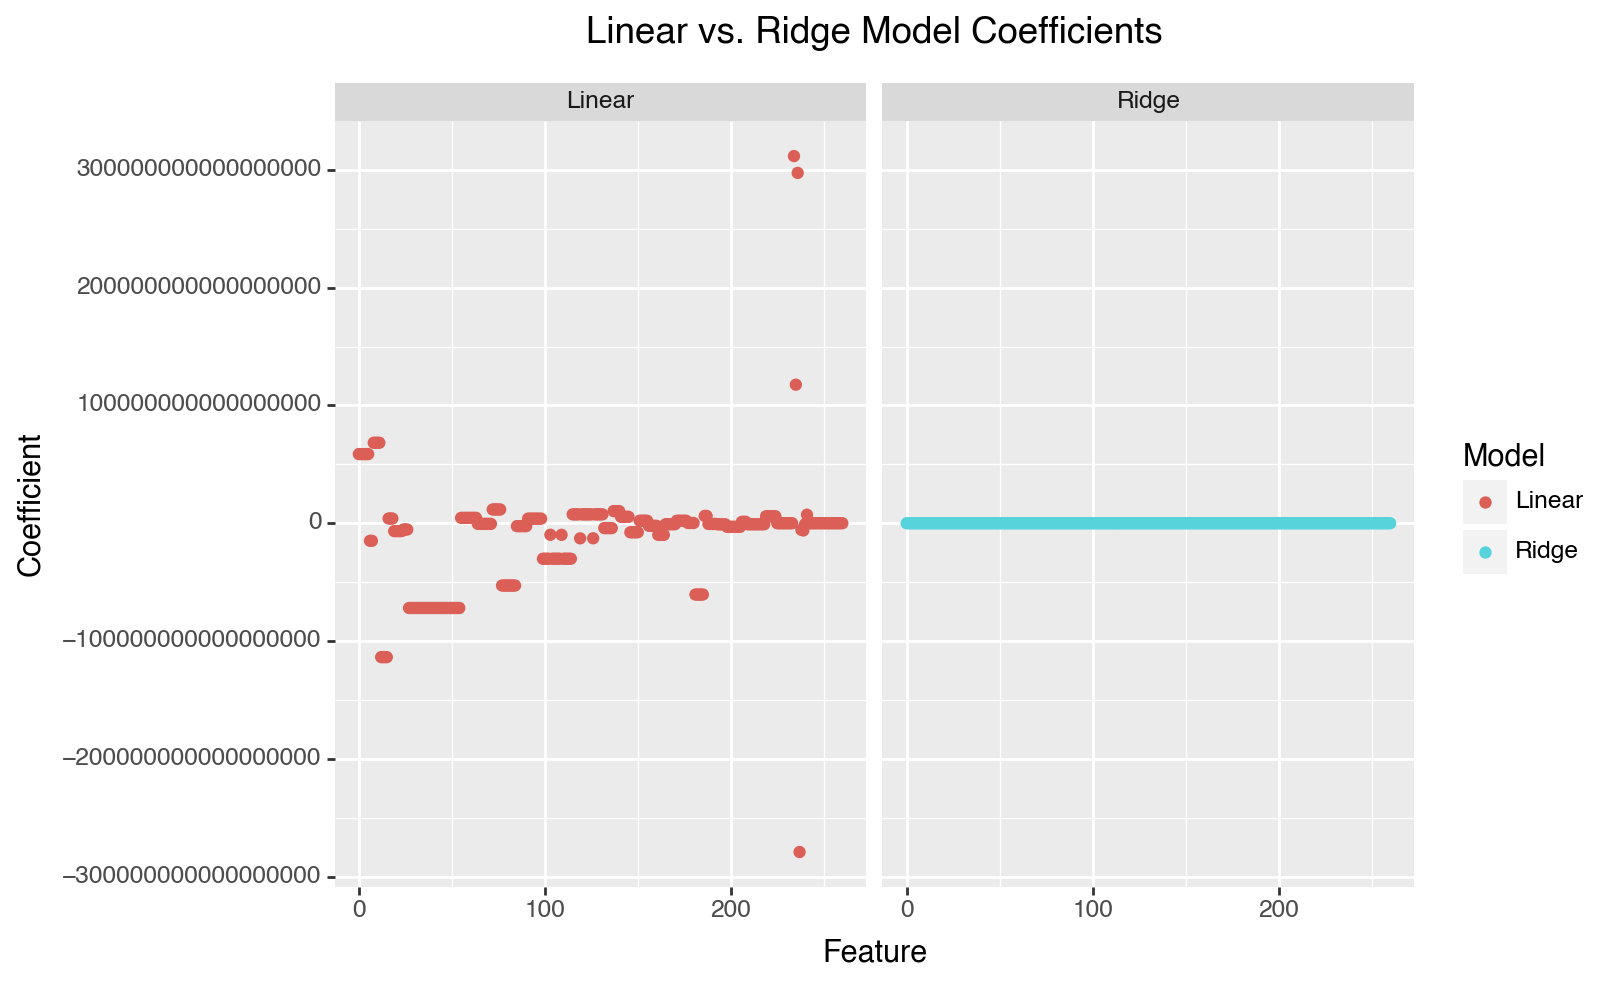

In [14]:
#Fit both models on entire df
lr_pipeline_1.fit(X, y)
ridge_pipeline.fit(X, y)

#Get coefficients
linear_coefs = lr_pipeline_1.named_steps['linear_regression'].coef_
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_

coefs_df = pd.DataFrame({
    'Coefficient': np.concatenate((ridge_coefs, linear_coefs)),
    'Model': ['Ridge'] * len(ridge_coefs) + ['Linear'] * len(linear_coefs),
    'Feature': list(range(len(ridge_coefs))) + list(range(len(linear_coefs)))
})

coefs_plot = (ggplot(coefs_df, aes(x='Feature', y='Coefficient', color='Model'))
    + geom_point()
    + labs(x='Feature', y='Coefficient', title='Linear vs. Ridge Model Coefficients')
    + theme(plot_title=element_text(ha='center'), figure_size=(8, 5))
    + facet_wrap('Model'))

print(coefs_plot)

# Part 2:

Using the same pipeline as previously, perform tuning on 
lambda.

You should always try values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [15]:
#Gridsearch csv Ridge Regression
from sklearn.model_selection import GridSearchCV

#Column Transformer
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), 
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

#Ridge pipeline
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

results = [.001,.01,.1,1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipeline, lambdas, cv = 5, scoring='r2')

In [16]:
gscv_fitted = gscv.fit(X, y)
pd.DataFrame(data = {"lambdas": results, "scores": gscv_fitted.cv_results_['mean_test_score']})

,lambdas,scores
0,0.001,0.852428
1,0.010,0.852705
2,0.100,0.854894
3,1.000,0.860648
4,10.000,0.863224
5,100.000,0.857921


# Part 3:

Create a LASSO pipeline, and tune lambda.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [17]:
#Gridsearch csv Lasso Regression
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), 
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

#Create lasso pipeline
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(tol=.01))]
)

results = [.001, .01, .1, 1, 10, 100, 1000]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipeline, lambdas, cv = 5, scoring='r2')

In [18]:
#lasso results
gscv_fitted = gscv.fit(X, y)
pd.DataFrame(data = {"lambda": results, "score": gscv_fitted.cv_results_['mean_test_score']})

/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.164e+11, tolerance: 1.348e+11
/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.775e+11, tolerance: 1.474e+11
/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.616e+11, tolerance: 1.463e+11
/Users/kadenbuckley/anaco

,lambda,score
0,0.001,0.853952
1,0.010,0.854056
2,0.100,0.854893
3,1.000,0.855415
4,10.000,0.859285
5,100.000,0.866193
6,1000.000,0.839775


# Part 4:

Create an Elastic Net pipeline, and tune lambda and alpha.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [19]:
#Column transformer
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
         make_column_selector(dtype_include=object)),  # for categorical features
        ("standardize", StandardScaler(), 
         make_column_selector(dtype_include=np.number))  # for numeric features
    ],
    remainder="passthrough"
)

#pipeline
enet_pipeline = Pipeline(
    [("preprocessing", ct),
     ("enet_regression", ElasticNet())]
)

# Define the grid of parameters to search over
lambdas = {
    'enet_regression__alpha': [.01, .1, 1],
    'enet_regression__l1_ratio': np.linspace(0, 1, 10)
}

# Define the GridSearchCV
gscv = GridSearchCV(enet_pipeline, lambdas, cv=5, scoring='r2')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Create a DataFrame with the grid search results for parameters
results_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

# Add the mean test scores to the DataFrame
results_df['mean_test_score'] = gscv_fitted.cv_results_['mean_test_score']

/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.719e+11, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.593e+11, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Rid

/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.060e+11, tolerance: 1.463e+09
/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.349e+11, tolerance: 1.407e+09
/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.247e+11, tolerance: 1.477e+09
/Users/kadenbuckley/anaco

/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e+12, tolerance: 1.407e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/Users/kadenbuckley/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e+12, tolerance: 1.477e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Rid

In [20]:
results_df

,enet_regression__alpha,enet_regression__l1_ratio,mean_test_score
0,0.01,0.000000,0.862896
1,0.01,0.111111,0.863027
2,0.01,0.222222,0.863136
3,0.01,0.333333,0.863216
4,0.01,0.444444,0.863253
5,0.01,0.555556,0.863225
6,0.01,0.666667,0.863099
7,0.01,0.777778,0.862800
8,0.01,0.888889,0.862081
9,0.01,1.000000,0.854056
